In [1]:
!date

Mon Nov 25 22:44:52 PST 2019


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import anndata
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from kb_python.utils import import_matrix_as_anndata
from scipy.sparse import csr_matrix
from scipy.io import mmread, mmwrite
from matplotlib_venn import venn3
from sklearn.metrics import adjusted_rand_score
from scipy import stats

plt.rcParams.update({'font.size': 18})

%config InlineBackend.figure_format = 'retina'

In [3]:
fsize = 20
gridalpha = 0.2

def knee_plot(mtx, ax=None, **kwargs):
    '''
        Makes knee plot.
        A: adata
        kwargs: [c = _lighten_color(B_color, 0.5), linewidth=2, alpha=1]
    '''
    ax = ax or plt.gca()

    ranked_umi = np.sort(mtx, axis=None)[::-1] # reversed
    ax.plot(ranked_umi, np.arange(len(ranked_umi)), **kwargs)
    return ax

def knee_plot_settings(mtx, ax=None):
    ax = ax or plt.gca()
    
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_yscale("log", nonposy='clip')
    ax.set_xlabel('UMI counts',fontsize=fsize)
    ax.set_ylabel('Cumulative number of barcodes',fontsize=fsize)
    ax.set_title('',loc='center')
    #ax.set_title('A', fontweight='bold', fontsize = fsize, loc = 'left' )
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)


    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])
    return ax

def plot_embedding(Y, comp=[0,1], labels=None, ax=None, plot_label=None):
    x = Y[:,comp[0]]
    y = Y[:,comp[1]]

    ax = ax or plt.gca()

    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("{}1".format(plot_label))
    ax.set_ylabel("{}2".format(plot_label))
    if plot_label is None:
        plot_label = ""

    if labels is not None:
        ax.scatter(x,y, c=labels, cmap="tab20b", label=plot_label)
        ax.legend(markerscale = 0)
        return ax
    ax.scatter(x,y, color="black")
    return ax

def plot_bulk(X, Y, xlabel=None, ylabel=None, ax=None):
    ax = ax or plt.gca()
    
    ax.set_xlim((10, 10**6))
    ax.set_ylim((10, 10**6))
    ax.set_xlabel(xlabel, fontsize=fsize)
    ax.set_ylabel(ylabel, fontsize=fsize)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_yscale("log", nonposy='clip')
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    
    
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)
    
    ax.scatter(X, Y, c="black", s=10, alpha=0.2)

    return ax

def _sparse_M_std(X):
    n = X.shape[0]
    return np.sqrt(n * X.multiply(X).sum(0) - np.multiply(X.sum(0), X.sum(0)))

def sparse_M_corr(X, Y):
    '''
        Computes Pearson correlation between X and Y (both in sparse format). Must be same shape.
        X: A_raw[common_obs.index].layers['log1p'] # raw
        Y: B_raw[common_obs.index].layers['log1p']# raw
        X: A.layers['log1p'] # filtered
        Y: B.layers['log1p'] # filtered
        Notes: I changed the axis in sum and shape, need to check if right
    '''
    X_std = _sparse_M_std(X)
    Y_std = _sparse_M_std(Y)
    XY_std = np.multiply(X_std, Y_std)
    n = X.shape[0]
    XY_cov = n*X.multiply(Y).sum(0) - np.multiply(X.sum(0), Y.sum(0))
    R = np.divide(XY_cov, XY_std)
    return np.squeeze(np.asarray(R))

def corr_plot(X, Y, xlabel=None, ax=None, leg=None):
    ax = ax or plt.gca()

    ax.set_xscale('log')
    ax.set_xlim(1,10**6)
    ax.set_ylim(0,1)
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)
    ax.set_xlabel(xlabel, fontsize = fsize)
    ax.set_ylabel('Pearson Correlation', fontsize = fsize)
    handles, labels = ax.get_legend_handles_labels()
    #ax.legend(handles[::-1], labels[::-1])

    ax.scatter(X, Y, c="black", s=10, alpha=0.2, label=leg[0]+" vs. "+leg[1])
    ax.legend()
    return ax

# kite: Cell-Hashing HTO

In [4]:
samples = 8
random_state = 42

In [5]:
raw = anndata.read_h5ad("/home/sina/projects/kite/cell-hashing/kite_out/counts_unfiltered/adata.h5ad")
raw.obs["counts"] = raw.X.sum(1)
raw.obs["num_nonzero"] = (raw.X>0).sum(1)
raw = raw[raw.obs["counts"]>0]

mtx = raw.X.todense()
raw.layers["norm"] = (mtx/raw.obs["counts"].values[:,None])*1000

adata = raw[raw.obs["counts"]>=45]
print(adata)

View of AnnData object with n_obs × n_vars = 66126 × 8 
    obs: 'counts', 'num_nonzero'
    layers: 'norm'


In [294]:
kmeans = KMeans(n_clusters=samples+1, random_state=random_state, init='k-means++')
pca = pca = PCA(n_components=2, random_state=random_state)
tsne = TSNE(random_state=random_state)
umap = UMAP(random_state=random_state)

In [295]:
kmeans.fit(adata.layers["norm"])
YY_pca = pca.fit_transform(adata.layers["norm"])
YY_tsne = tsne.fit_transform(adata.layers["norm"])
YY_umap = umap.fit_transform(adata.layers["norm"])

In [296]:
adata.obs["kmeans"] = kmeans.labels_

adata.obs["PCA0"] = YY_pca[:,0]
adata.obs["PCA1"] = YY_pca[:,1]

adata.obs["TSNE0"] = YY_tsne[:,0]
adata.obs["TSNE1"] = YY_tsne[:,1]

adata.obs["UMAP0"] = YY_umap[:,0]
adata.obs["UMAP1"] = YY_umap[:,1]


Trying to set attribute `.obs` of view, making a copy.


Save assignments

In [6]:
#adata.write_h5ad("./save/kite_adata.h5ad")
adata = anndata.read_h5ad("./save/kite_adata.h5ad")

## Load Paper Data

### Old hto counts (Cell-Hashing paper)

In [297]:
old_hto = pd.read_csv("/home/sina/projects/kmuxlet/cell_hashing/GEO_files/Hashtag-HTO-count.csv", index_col=0).T.sort_index()
old_hto = old_hto.loc[:,'BatchA-AGGACCATCCAA':'BatchH-TATCACATCGGT']
old_hto = old_hto[old_hto.values.sum(1)>0]
mtx = old_hto.values/old_hto.values.sum(1)[:,None]*1000
old_hto = anndata.AnnData(old_hto)
old_hto.layers["norm"] = mtx

In [310]:
old_hto.obs["counts"] = old_hto.X.sum(1)

### New hto counts (Cite-Seq 1.4) w/ WHITELIST

In [22]:
path = "/home/sina/projects/kite/cell-hashing/cite_seq_out_no_UMI_correction/umi_count/"
mtx = path + "matrix.mtx.gz"
mtx = mmread(mtx)
mmwrite(path + "matrix_T.mtx", mtx.T)

In [24]:
gen = path + "features.tsv.gz"
bcs = path + "barcodes.tsv.gz"
mtx = path + "matrix_T.mtx.gz"

new_hto = import_matrix_as_anndata(mtx, bcs, gen)
new_hto = new_hto[new_hto.obs.sort_index().index.values]

In [25]:
new_hto = new_hto[:,0:8]

In [26]:
new_hto.obs["counts"] = new_hto.X.sum(1)

Trying to set attribute `.obs` of view, making a copy.


In [27]:
dense = new_hto.X.todense()
mtx = dense/dense.sum(1)*1000
new_hto.layers["norm"] = mtx

/home/sina/tools/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


### New hto READ counts

In [16]:
path = "/home/sina/projects/kite/cell-hashing/cite_seq_out_no_UMI_correction/read_count/"
mtx = path + "matrix.mtx.gz"
mtx = mmread(mtx)
mmwrite(path + "matrix_T.mtx", mtx.T)

In [18]:
gen = path + "features.tsv.gz"
bcs = path + "barcodes.tsv.gz"
mtx = path + "matrix_T.mtx.gz"

new_read_hto = import_matrix_as_anndata(mtx, bcs, gen)
new_read_hto = new_read_hto[new_read_hto.obs.sort_index().index.values]

In [19]:
new_read_hto = new_read_hto[:,0:8]

In [20]:
new_read_hto.obs["counts"] = new_read_hto.X.sum(1)

Trying to set attribute `.obs` of view, making a copy.


In [21]:
dense = new_read_hto.X.todense()
mtx = dense/dense.sum(1)*1000
new_read_hto.layers["norm"] = mtx

/home/sina/tools/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


## Compute everything on new and old HTO count matrices

* OLD *

In [301]:
kmeans = KMeans(n_clusters=samples+1, random_state=random_state, init='k-means++')
pca = pca = PCA(n_components=2, random_state=random_state)
tsne = TSNE(random_state=random_state)
umap = UMAP(random_state=random_state)

In [302]:
kmeans.fit(old_hto.layers["norm"])
YY_pca = pca.fit_transform(old_hto.layers["norm"])
YY_tsne = tsne.fit_transform(old_hto.layers["norm"])
YY_umap = umap.fit_transform(old_hto.layers["norm"])

In [303]:
old_hto.obs["kmeans"] = kmeans.labels_

old_hto.obs["PCA0"] = YY_pca[:,0]
old_hto.obs["PCA1"] = YY_pca[:,1]

old_hto.obs["TSNE0"] = YY_tsne[:,0]
old_hto.obs["TSNE1"] = YY_tsne[:,1]

old_hto.obs["UMAP0"] = YY_umap[:,0]
old_hto.obs["UMAP1"] = YY_umap[:,1]


In [7]:
# old_hto.write_h5ad("./save/old_hto_adata.h5ad")
old_hto = anndata.read_h5ad("./save/old_hto_adata.h5ad")

* NEW *

In [461]:
kmeans = KMeans(n_clusters=samples+1, random_state=random_state, init='k-means++')
pca = pca = PCA(n_components=2, random_state=random_state)
tsne = TSNE(random_state=random_state)
umap = UMAP(random_state=random_state)

In [462]:
kmeans.fit(new_hto.layers["norm"])
YY_pca = pca.fit_transform(new_hto.layers["norm"])
YY_tsne = tsne.fit_transform(new_hto.layers["norm"])
YY_umap = umap.fit_transform(new_hto.layers["norm"])

In [463]:
new_hto.obs["kmeans"] = kmeans.labels_

new_hto.obs["PCA0"] = YY_pca[:,0]
new_hto.obs["PCA1"] = YY_pca[:,1]

new_hto.obs["TSNE0"] = YY_tsne[:,0]
new_hto.obs["TSNE1"] = YY_tsne[:,1]

new_hto.obs["UMAP0"] = YY_umap[:,0]
new_hto.obs["UMAP1"] = YY_umap[:,1]


Trying to set attribute `.obs` of view, making a copy.


In [471]:
new_hto.write_h5ad("./save/new_hto_adata.h5ad")

* NEW READ *

In [464]:
kmeans = KMeans(n_clusters=samples+1, random_state=random_state, init='k-means++')
pca = pca = PCA(n_components=2, random_state=random_state)
tsne = TSNE(random_state=random_state)
umap = UMAP(random_state=random_state)

In [465]:
kmeans.fit(new_read_hto.layers["norm"])
YY_pca = pca.fit_transform(new_read_hto.layers["norm"])
YY_tsne = tsne.fit_transform(new_read_hto.layers["norm"])
YY_umap = umap.fit_transform(new_read_hto.layers["norm"])

In [466]:
new_read_hto.obs["kmeans"] = kmeans.labels_
new_read_hto.obs["PCA0"] = YY_pca[:,0]
new_read_hto.obs["PCA1"] = YY_pca[:,1]
new_read_hto.obs["TSNE0"] = YY_tsne[:,0]
new_read_hto.obs["TSNE1"] = YY_tsne[:,1]
new_read_hto.obs["UMAP0"] = YY_umap[:,0]
new_read_hto.obs["UMAP1"] = YY_umap[:,1]


In [472]:
new_read_hto.write_h5ad("./save/new_read_hto_adata.h5ad")

# Data Visualizations

In [28]:
all_bcs = [adata.obs.index.values, old_hto.obs.index.values, new_hto.obs.index.values]

common_bcs = np.sort(np.array(list(set.intersection(*map(set,all_bcs)))))

In [29]:
cmp_adata = adata[adata.obs.index.isin(common_bcs)].obs.index.values
cmp_old_hto = old_hto[old_hto.obs.index.isin(common_bcs)].obs.index.values
cmp_new_hto = new_hto[new_hto.obs.index.isin(common_bcs)].obs.index.values

## Compare kmeans clustering on the common barcodes

1.0 is perfect

In [30]:
print("kite vs new hto: ", adjusted_rand_score(cmp_adata, cmp_new_hto))
print("kite vs old hto: ", adjusted_rand_score(cmp_adata, cmp_old_hto))
print("new  vs old hto: ", adjusted_rand_score(cmp_old_hto, cmp_new_hto))

kite vs new hto:  1.0
kite vs old hto:  1.0
new  vs old hto:  1.0


## Look at knee plot

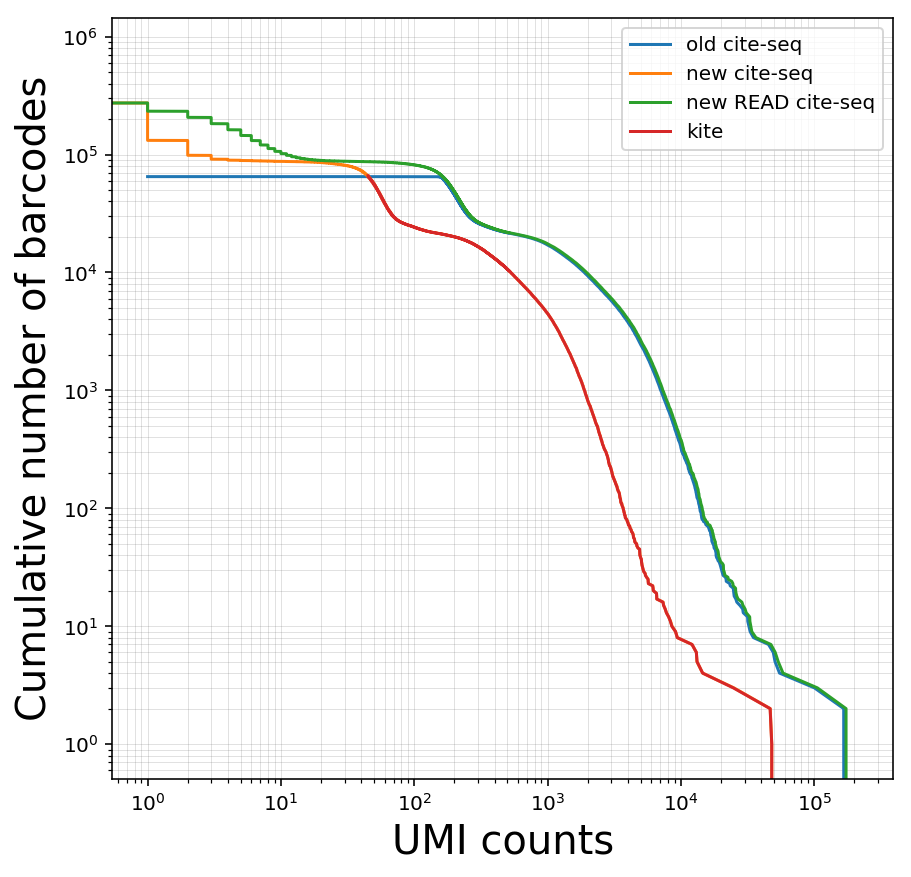

In [31]:
fig, ax = plt.subplots(figsize=(7, 7))

ax = knee_plot(old_hto.obs["counts"], ax, label="old cite-seq")
knee_plot_settings(old_hto.obs["counts"], ax)

ax = knee_plot(new_hto.obs["counts"], ax, label="new cite-seq")
knee_plot_settings(new_hto.obs["counts"], ax)

ax = knee_plot(new_read_hto.obs["counts"], ax, label="new READ cite-seq")
knee_plot_settings(new_read_hto.obs["counts"], ax)

ax = knee_plot(adata.obs["counts"], ax, label="kite")
knee_plot_settings(adata.obs["counts"], ax)

plt.legend()

plt.show()

## How well do the barcodes overlap

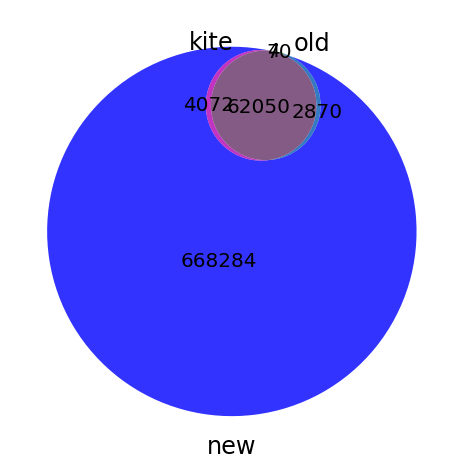

In [26]:
fig, ax = plt.subplots(figsize=(4,4))

set1 = set(adata.obs.index.values) # kite
set2 = set(old_hto.obs.index.values)
set3 = set(new_hto.obs.index.values)

venn3([set1, set2, set3], ('kite', 'old', 'new'), alpha=0.8)
plt.show()

## PCA on normalized counts

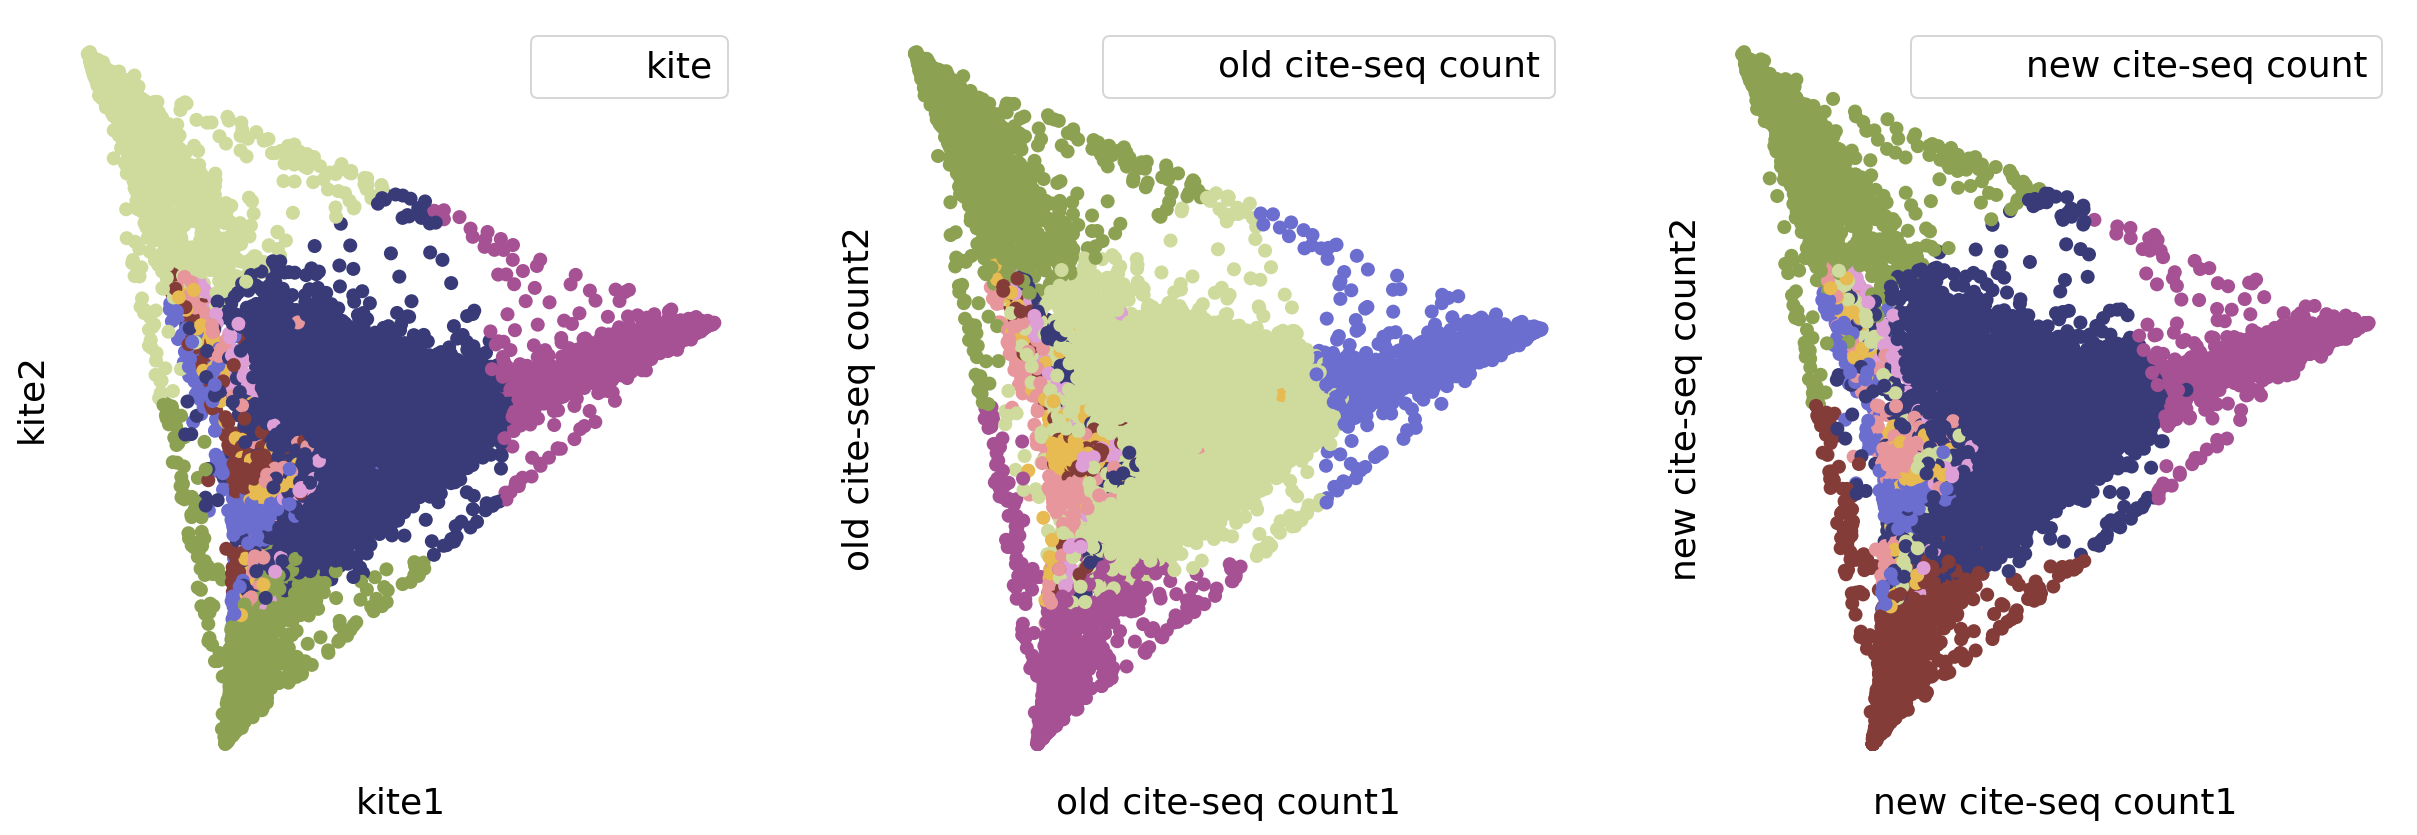

In [483]:
fig, ax = plt.subplots(figsize=(7*3, 7), ncols=3)


plot_embedding(adata.obs.loc[:,"PCA0":"PCA1"].values, ax=ax[0], labels=adata.obs.loc[:,"kmeans"].values, plot_label="kite")
plot_embedding(old_hto.obs.loc[:,"PCA0":"PCA1"].values, ax=ax[1], labels=old_hto.obs.loc[:,"kmeans"].values, plot_label="old cite-seq count")
plot_embedding(new_hto.obs.loc[:,"PCA0":"PCA1"].values, ax=ax[2], labels=new_hto.obs.loc[:,"kmeans"].values, plot_label="new cite-seq count")

plt.show()

## UMAP on normalized counts

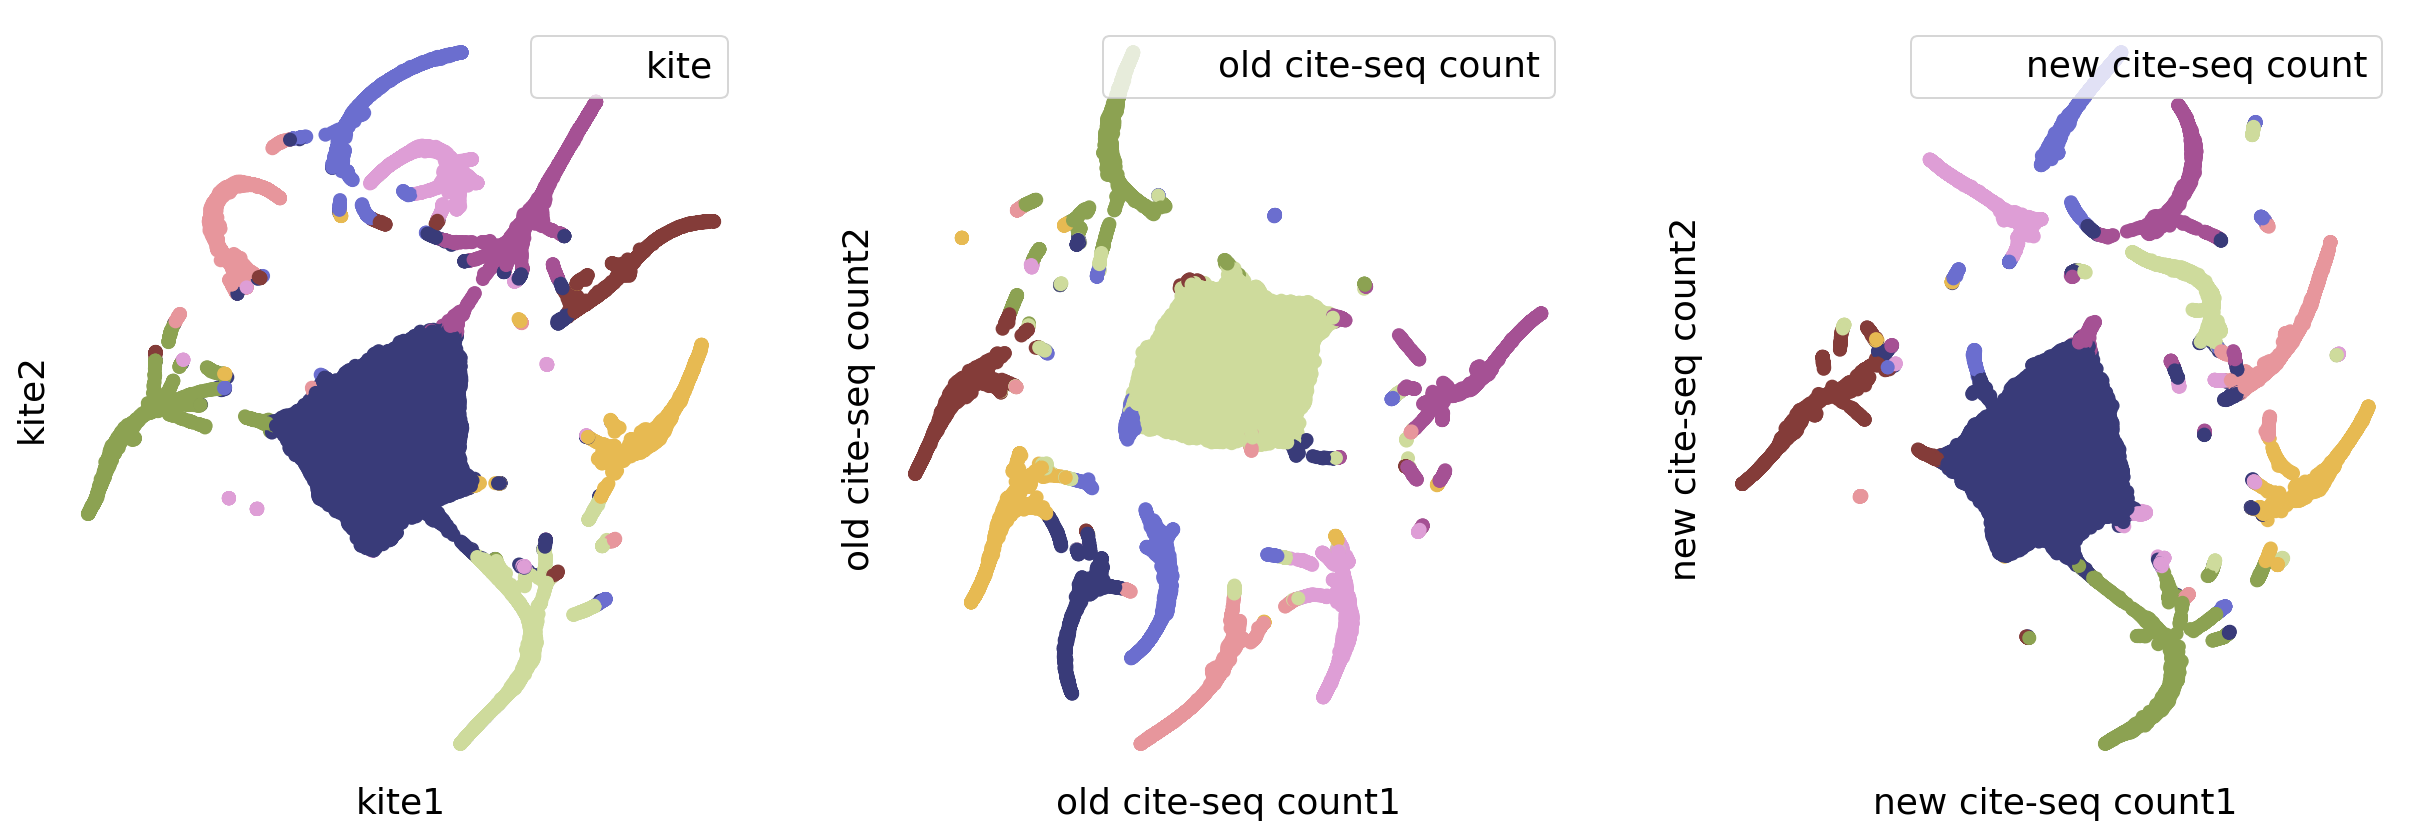

In [478]:
fig, ax = plt.subplots(figsize=(7*3, 7), ncols=3)

plot_embedding(adata.obs.loc[:,"UMAP0":"UMAP1"].values, ax=ax[0], labels=adata.obs.loc[:,"kmeans"].values, plot_label="kite")
plot_embedding(old_hto.obs.loc[:,"UMAP0":"UMAP1"].values, ax=ax[1], labels=old_hto.obs.loc[:,"kmeans"].values, plot_label="old cite-seq count")
plot_embedding(new_hto.obs.loc[:,"UMAP0":"UMAP1"].values, ax=ax[2], labels=new_hto.obs.loc[:,"kmeans"].values, plot_label="new cite-seq count")

plt.show()

## tSNE on normalized counts

In [473]:
# plot the number of counts
# make colors discrete

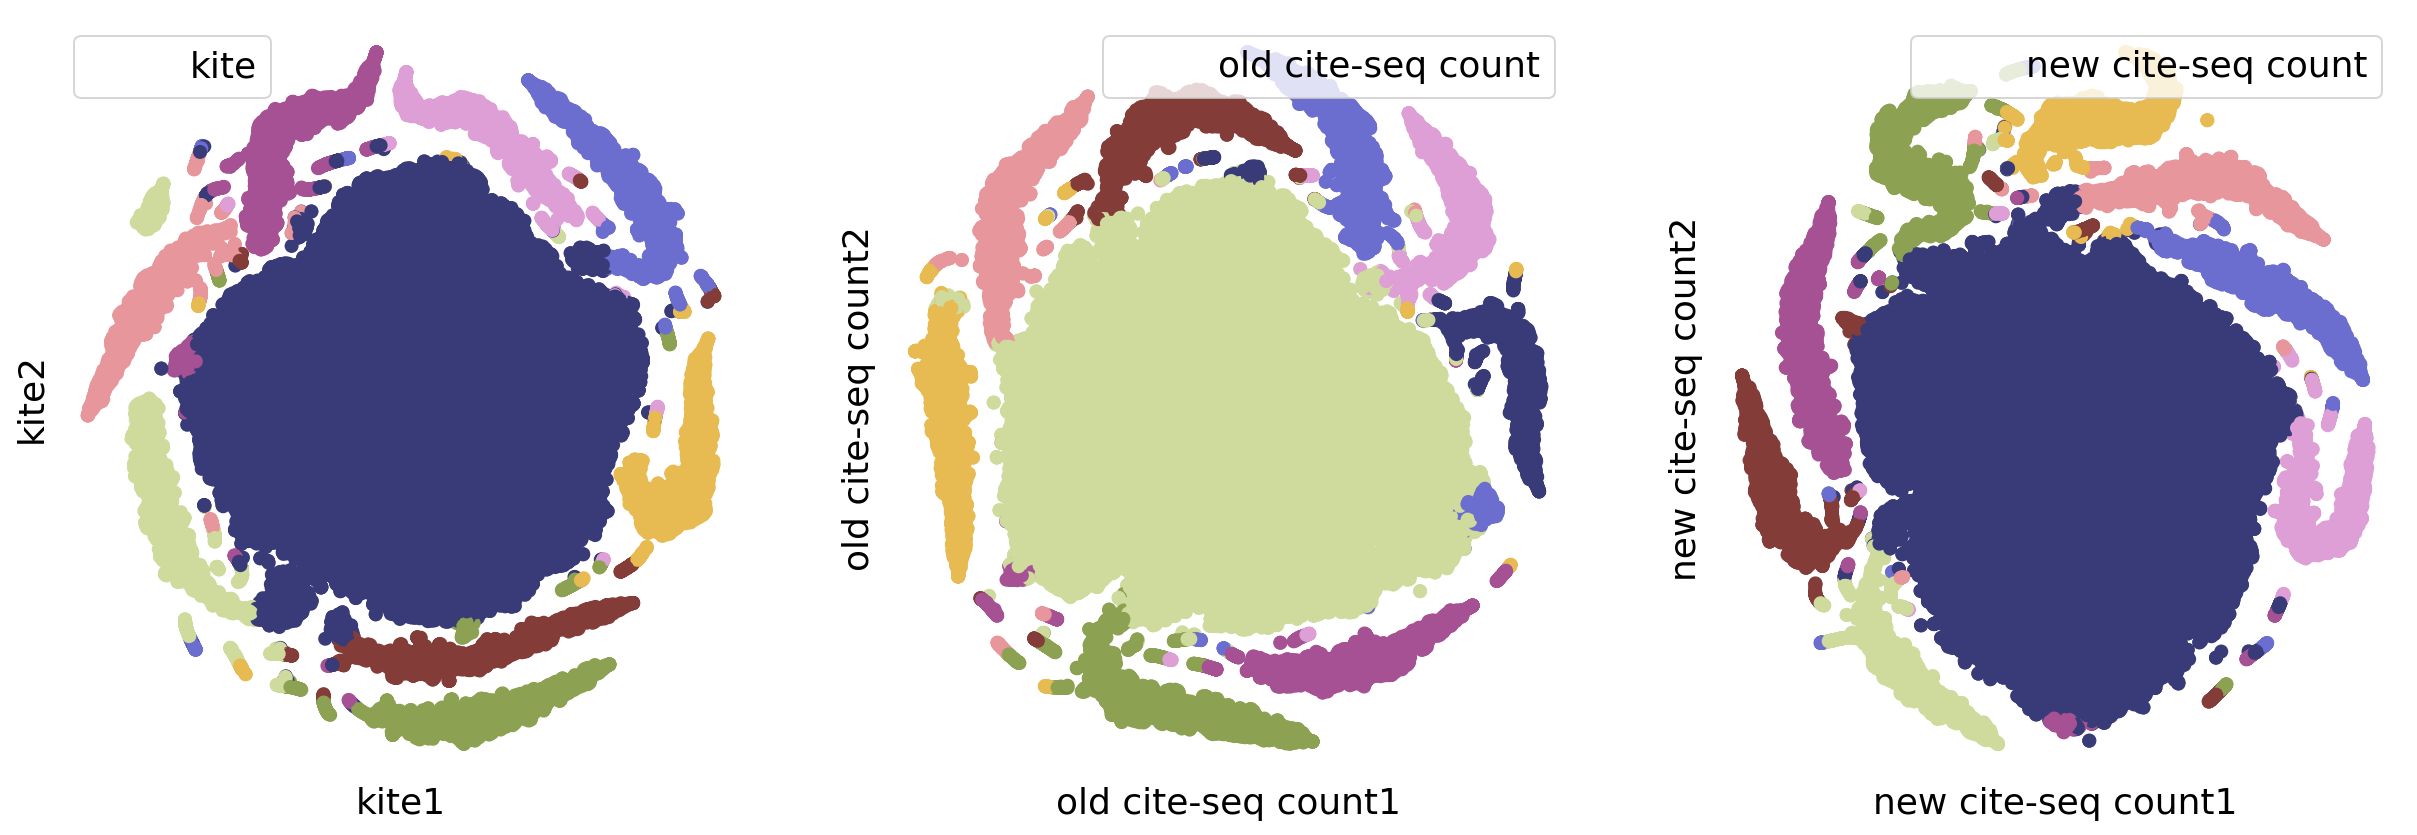

In [479]:
fig, ax = plt.subplots(figsize=(7*3, 7), ncols=3)

plot_embedding(adata.obs.loc[:,"TSNE0":"TSNE1"].values, ax=ax[0], labels=adata.obs.loc[:,"kmeans"].values, plot_label="kite")
plot_embedding(old_hto.obs.loc[:,"TSNE0":"TSNE1"].values, ax=ax[1], labels=old_hto.obs.loc[:,"kmeans"].values, plot_label="old cite-seq count")
plot_embedding(new_hto.obs.loc[:,"TSNE0":"TSNE1"].values, ax=ax[2], labels=new_hto.obs.loc[:,"kmeans"].values, plot_label="new cite-seq count")

plt.show()

## Each dot is a cell, sum counts and compare

In [27]:
adata_bulk = adata[adata.obs.index.isin(common_bcs)].obs.counts
new_hto_bulk = new_hto[new_hto.obs.index.isin(common_bcs)].obs.counts
old_hto_bulk = old_hto[old_hto.obs.index.isin(common_bcs)].obs.counts
new_read_hto_bulk = new_read_hto[new_read_hto.obs.index.isin(common_bcs)].obs.counts

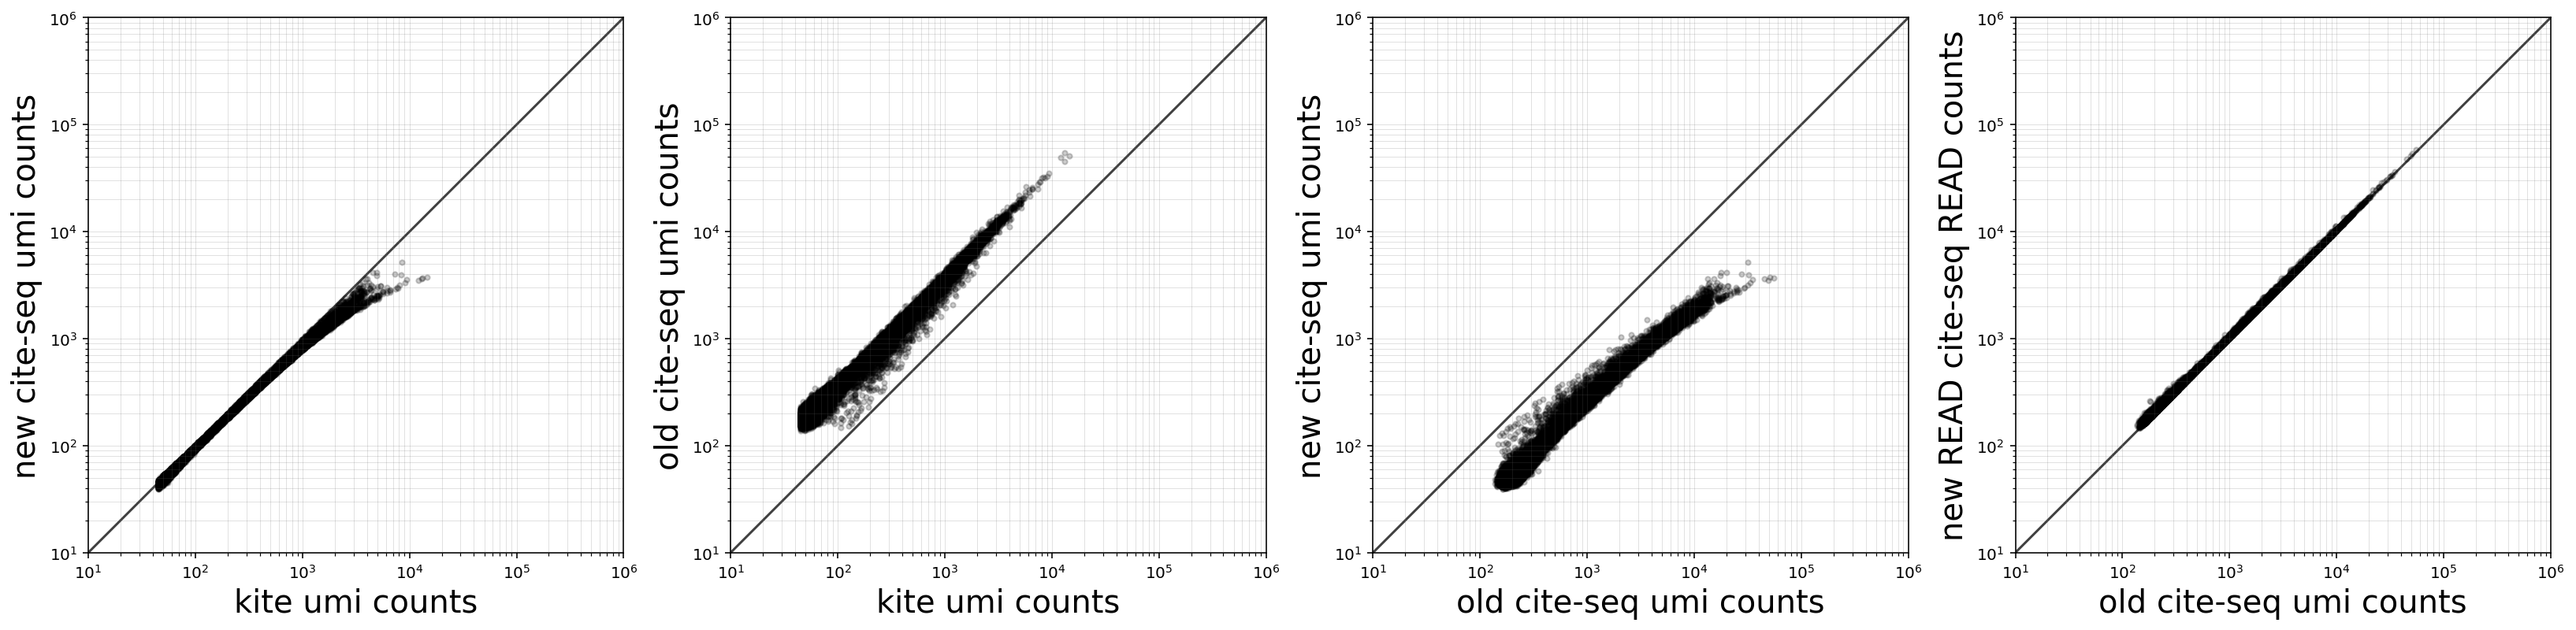

In [28]:
fig, ax = plt.subplots(figsize=(7*4, 7), ncols=4)


plot_bulk(adata_bulk, new_hto_bulk, xlabel="kite umi counts", ylabel="new cite-seq umi counts", ax=ax[0])
plot_bulk(adata_bulk, old_hto_bulk, xlabel="kite umi counts", ylabel="old cite-seq umi counts", ax=ax[1])
plot_bulk(old_hto_bulk, new_hto_bulk, xlabel="old cite-seq umi counts", ylabel="new cite-seq umi counts", ax=ax[2])

plot_bulk(old_hto_bulk, new_read_hto_bulk, xlabel="old cite-seq umi counts", ylabel="new READ cite-seq READ counts", ax=ax[3])


plt.show()

In [29]:
print("r-squared values\n--")
slope, intercept, r_value, p_value, std_err = stats.linregress(adata_bulk, new_hto_bulk)
print("kite & new cite-seq:\t\t", r_value**2)

slope, intercept, r_value, p_value, std_err = stats.linregress(adata_bulk, old_hto_bulk)
print("kite & old cite-seq:\t\t", r_value**2)

slope, intercept, r_value, p_value, std_err = stats.linregress(old_hto_bulk, new_hto_bulk)
print("old cite-seq & new cite-seq:\t", r_value**2)

slope, intercept, r_value, p_value, std_err = stats.linregress(old_hto_bulk, new_read_hto_bulk)
print("old cite-seq & new READ cite-seq:\t", r_value**2)

r-squared values
--
kite & new cite-seq:		 0.9485525596313168
kite & old cite-seq:		 0.9922911984153099
old cite-seq & new cite-seq:	 0.935073142942589
old cite-seq & new READ cite-seq:	 0.9997661111686347


## Pearson correlation on barcodes

In [30]:
old_hto.X = csr_matrix(old_hto.X)

In [31]:
corr_1= sparse_M_corr(adata[common_bcs].X.T, new_hto[common_bcs].X.T)
corr_2 = sparse_M_corr(adata[common_bcs].X.T, old_hto[common_bcs].X.T)
corr_3 = sparse_M_corr(old_hto[common_bcs].X.T, new_hto[common_bcs].X.T)
corr_4 = sparse_M_corr(old_hto[common_bcs].X.T, new_read_hto[common_bcs].X.T)

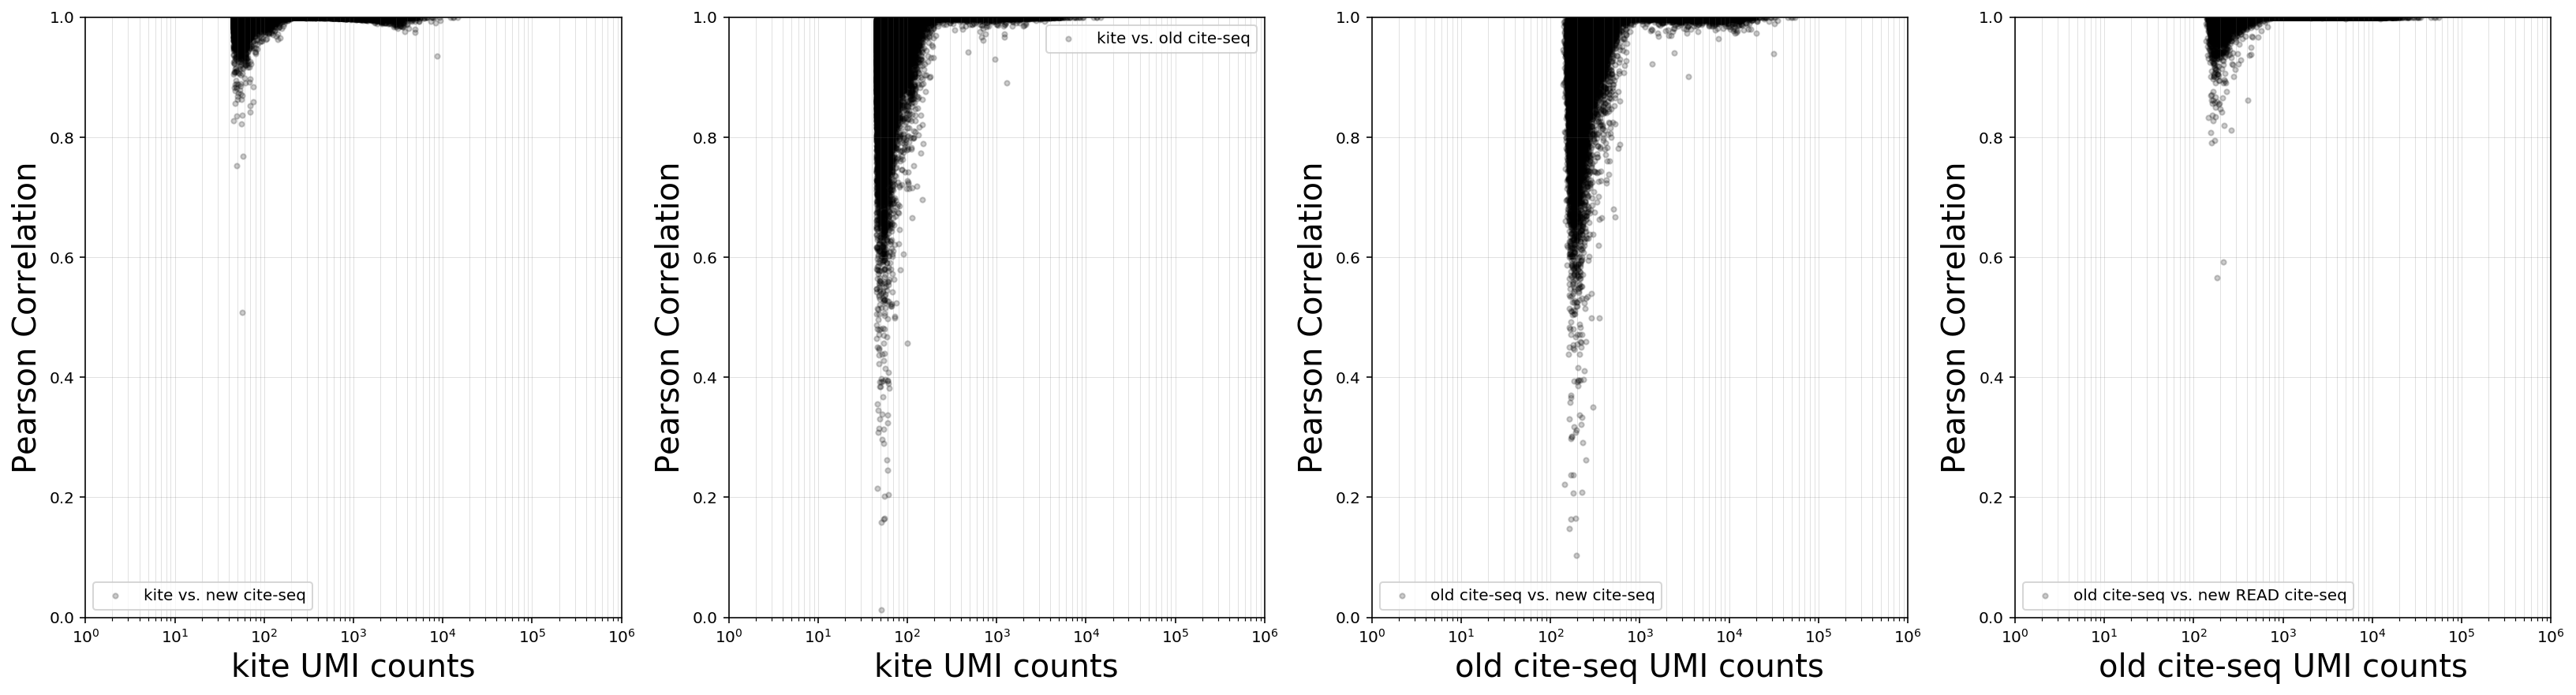

In [32]:
fig, ax = plt.subplots(figsize=(7*4, 7), ncols=4)

corr_plot(adata[common_bcs].obs["counts"].values, corr_1, ax=ax[0], xlabel="kite UMI counts", leg=["kite", "new cite-seq"])
corr_plot(adata[common_bcs].obs["counts"].values, corr_2, ax=ax[1], xlabel="kite UMI counts", leg=["kite", "old cite-seq"])
corr_plot(old_hto[common_bcs].obs["counts"].values, corr_3, ax=ax[2], xlabel="old cite-seq UMI counts", leg=["old cite-seq", "new cite-seq"])

corr_plot(old_hto[common_bcs].obs["counts"].values, corr_4, ax=ax[3], xlabel="old cite-seq UMI counts", leg=["old cite-seq", "new READ cite-seq"])


plt.legend()
plt.show()

# Comparing Clustering

In [56]:
jaccard = np.zeros((samples +1, samples +1))

In [57]:
jaccard

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [59]:
new_hto.obs

,counts
barcode,
AAACCTGAGAAACCAT,0.0
AAACCTGAGAAACCGC,0.0
AAACCTGAGAAACCTA,0.0
AAACCTGAGAAACGAG,2.0
AAACCTGAGAAACGCC,0.0
AAACCTGAGAAAGTGG,0.0
AAACCTGAGAACAACT,1.0
AAACCTGAGAACAATC,1.0
AAACCTGAGAACTCGG,1.0
